# NIHCXR Clinical Drift Experiments Tutorial

## Import Libraries and Load NIHCXR Dataset

In [1]:
from functools import partial

from monai.transforms import AddChanneld, Compose, Lambdad, Resized, ToDeviced
from torchxrayvision.models import DenseNet

from cyclops.data.loader import load_nihcxr
from cyclops.data.slicer import SliceSpec
from cyclops.data.utils import apply_transforms
from cyclops.monitor import ClinicalShiftApplicator, Detector, Reductor, TSTester
from cyclops.monitor.plotter import plot_drift_experiment, plot_drift_timeseries
from cyclops.monitor.utils import get_device

device = get_device()

nih_ds = load_nihcxr("/mnt/data/clinical_datasets/NIHCXR")

/home/amritk/.cache/pypoetry/virtualenvs/pycyclops-Svpk0lXb-py3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Example 1. Generate Source/Target Dataset for Experiments (1-2)

In [2]:
shifter = ClinicalShiftApplicator(
    "sex", source=None, target="F", shift_id="Patient Gender"
)
source_ds, target_ds = shifter.apply_shift(nih_ds, num_proc=6)

transforms = Compose(
    [
        AddChanneld(keys=("features",), allow_missing_keys=True),
        Resized(
            keys=("features",), spatial_size=(1, 224, 224), allow_missing_keys=True
        ),
        Lambdad(
            keys=("features",),
            func=lambda x: ((2 * (x / 255.0)) - 1.0) * 1024,
            allow_missing_keys=True,
        ),
        ToDeviced(keys=("features",), device=device, allow_missing_keys=True),
    ]
)

source_ds = source_ds.with_transform(
    partial(apply_transforms, transforms=transforms),
    columns=["features"],
    output_all_columns=True,
)
target_ds = target_ds.with_transform(
    partial(apply_transforms, transforms=transforms),
    columns=["features"],
    output_all_columns=True,
)

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 71473.02 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 100743.47 examples/s]

Filter (num_proc=6):  47%|████▋     | 52374/112120 [00:00<00:00, 101360.57 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 142548.63 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:00<00:00, 151623.34 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 63731.23 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 102007.64 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 124590.23 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 138391.08 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 143799.39 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:00<00:00, 148877.82 examples/s]

## Example 2. Sensitivity test experiment with 3 dimensionality reduction techniques


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:02<00:11, 14.79 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:05, 26.53 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:02, 35.41 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 42.17 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 47.51 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 50.95 examples/s]

Map: 100%|██████████| 200/200 [00:05<00:00, 50.44 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.12 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.05 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:02<00:04, 15.77 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 28.15 examples/s]

Map:  96%|█████████▌| 96/100 [00:03<00:00, 37.15 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:10, 16.05 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 28.09 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:02, 35.27 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 39.12 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 44.28 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 47.79 examples/s]

Map: 100%|██████████| 200/200 [00:05<00:00, 47.72 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:02<00:10, 15.76 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:05, 26.93 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:03, 34.60 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 40.60 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 45.11 examples/s]

Map:  96%|█████████▌| 192/200 [00:05<00:00, 47.20 examples/s]

Map: 100%|██████████| 200/200 [00:05<00:00, 46.83 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.68 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.73 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:04, 16.57 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 27.87 examples/s]

Map:  96%|█████████▌| 96/100 [00:03<00:00, 35.23 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:10, 16.34 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 27.31 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:02, 35.05 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 40.38 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 43.66 examples/s]

Map:  96%|█████████▌| 192/200 [00:05<00:00, 45.53 examples/s]

Map: 100%|██████████| 200/200 [00:05<00:00, 45.37 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.64 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 29.61 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 37.06 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 42.94 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 47.07 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 49.42 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 50.01 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:02<00:01, 15.03 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 22.09 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.13 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 29.21 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 37.28 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.27 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 29.20 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:02, 36.87 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 41.75 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 46.17 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 48.20 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 48.38 examples/s]

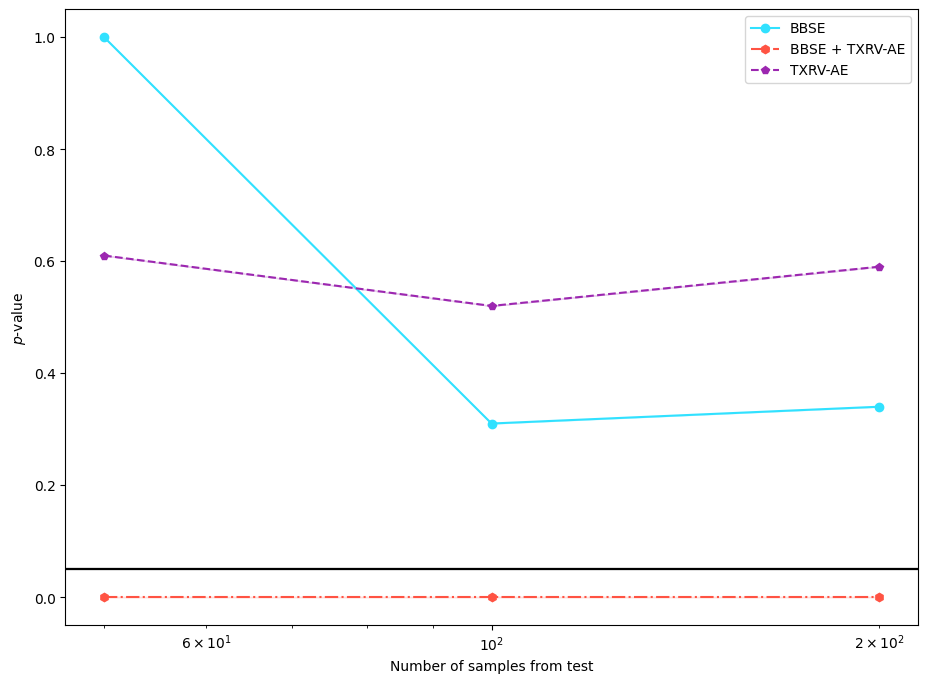

In [3]:
model = DenseNet(weights="densenet121-res224-all")
dr_methods = {
    "BBSE": "bbse-soft",
    "BBSE + TXRV-AE": "bbse-soft+txrv-ae",
    "TXRV-AE": "txrv-ae",
}
results = {}

for name, dr_method in dr_methods.items():
    if name == "TXRV-AE":
        reductor = Reductor(dr_method=dr_method, device=device)
    else:
        reductor = Reductor(dr_method=dr_method, model=model, device=device)
    detector = Detector(
        "sensitivity_test",
        reductor=reductor,
        tester=TSTester(tester_method="mmd"),
        source_sample_size=200,
        target_sample_size=[50, 100, 200],
        num_runs=1,
    )
    result = detector.detect_shift(source_ds, target_ds)
    results[name] = result
plot_drift_experiment(results)

## Example 3. Sensitivity test experiment with models trained on different datasets

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.33 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.53 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 40.15 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 46.54 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 50.06 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 54.23 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 54.32 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.92 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.75 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.69 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 30.44 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 39.68 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.83 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.32 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.38 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 45.52 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 50.10 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 53.20 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.84 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:02<00:10, 15.98 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 28.77 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 38.38 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 45.93 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 50.41 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.83 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.83 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.40 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.46 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.84 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 30.91 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 39.87 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.01 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.76 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 40.05 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 46.14 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 50.27 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.44 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 51.72 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 16.86 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.19 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.78 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 45.93 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 51.14 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.93 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 51.88 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.07 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.97 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.77 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 30.97 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 40.06 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.96 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.84 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.80 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 46.14 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 50.90 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 53.63 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 53.26 examples/s]

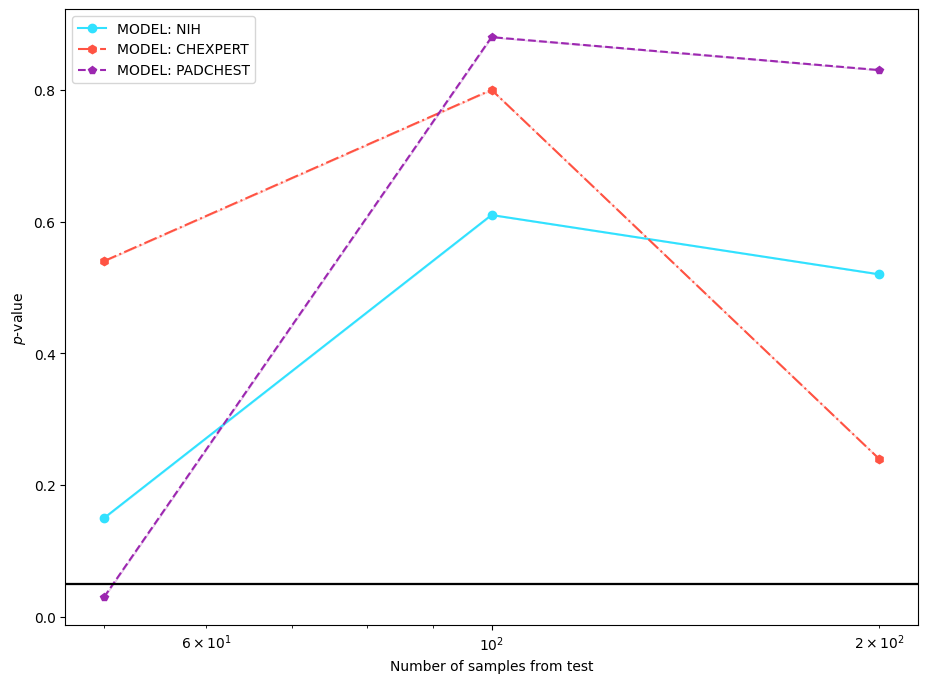

In [4]:
models = {
    "MODEL: NIH": "densenet121-res224-nih",
    "MODEL: CHEXPERT": "densenet121-res224-chex",
    "MODEL: PADCHEST": "densenet121-res224-pc",
}
results = {}

for model_name, model in models.items():
    detector = Detector(
        "sensitivity_test",
        reductor=Reductor(
            dr_method="bbse-soft", model=DenseNet(weights=model), device=device
        ),
        tester=TSTester(tester_method="mmd"),
        source_sample_size=200,
        target_sample_size=[50, 100, 200],
        num_runs=1,
    )
    results[model_name] = detector.detect_shift(source_ds, target_ds)
plot_drift_experiment(results)

## Example 4. Sensitivity test experiment with different clinical shifts

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 54393.46 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 75427.43 examples/s]

Filter (num_proc=6):  48%|████▊     | 54374/112120 [00:00<00:00, 88705.27 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 104246.10 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 104812.37 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 113668.00 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 49232.21 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 70265.85 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 85397.50 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 96312.67 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 103738.75 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 109326.76 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.14 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.09 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 38.98 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 46.18 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 51.57 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 54.95 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 54.59 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.77 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.73 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.79 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 30.80 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 39.50 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.71 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.33 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.58 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 44.50 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 49.73 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 53.24 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.64 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 53035.55 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 73913.42 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 81786.55 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 94051.01 examples/s]

Filter (num_proc=6):  80%|████████  | 89748/112120 [00:01<00:00, 92966.11 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 120563.09 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 52894.14 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 76639.62 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 89838.11 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 97644.27 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 103837.71 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 108286.67 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.17 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:05, 27.08 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:02, 35.72 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 42.47 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 47.44 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 50.90 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 50.81 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.63 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.57 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:04, 16.75 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 29.18 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 37.80 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:10, 16.11 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 28.31 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:02, 37.22 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 43.51 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 47.71 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 50.61 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 50.61 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 51669.63 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 81472.69 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 93602.66 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 98749.25 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 105787.38 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 107024.81 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 48303.95 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 77601.75 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 91844.63 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 100609.82 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 100691.58 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 111215.90 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.41 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 29.86 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 38.98 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 46.03 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 50.57 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 53.52 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 53.14 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.57 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.32 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:04, 16.33 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 28.58 examples/s]

Map:  96%|█████████▌| 96/100 [00:03<00:00, 37.60 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.84 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.55 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.69 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 46.29 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 51.09 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 53.50 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 53.37 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  16%|█▌        | 18000/112120 [00:00<00:01, 50502.89 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 79541.30 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 97744.66 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 95784.42 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 105080.34 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 110115.98 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 51811.62 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 71149.52 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 84801.08 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 93605.57 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 104591.08 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 116428.11 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:10, 16.66 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 27.97 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:02, 37.41 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 44.09 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 48.57 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.16 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 51.94 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.51 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.78 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.27 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 30.06 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 39.20 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.87 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.76 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.73 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 46.22 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 50.95 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 53.97 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 53.40 examples/s]

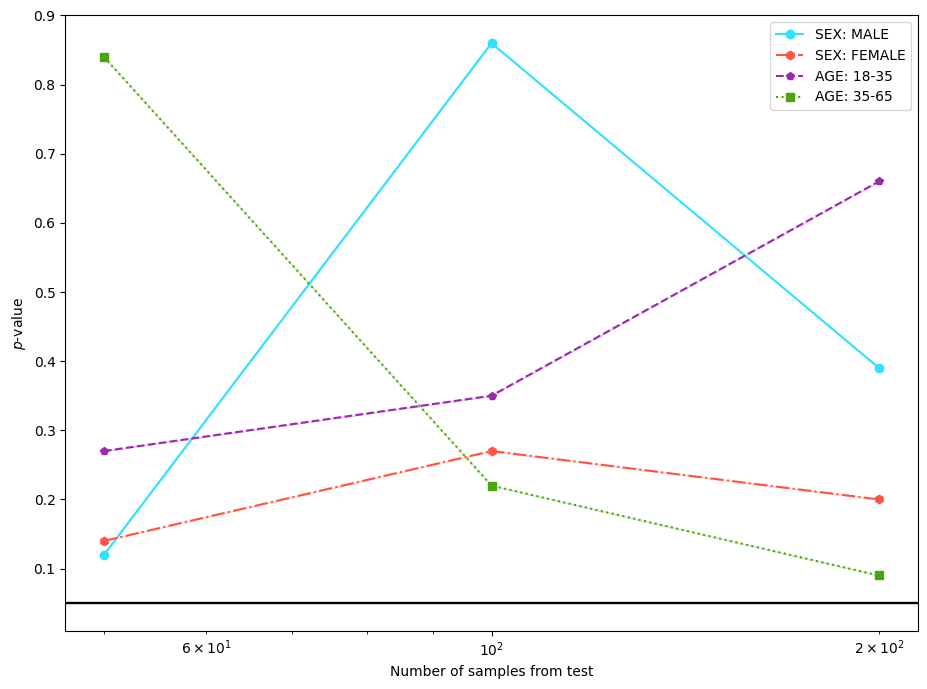

In [5]:
model = DenseNet(weights="densenet121-res224-all")
source_slice = None
target_slices = {
    "SEX: MALE": SliceSpec(spec_list=[{"Patient Gender": {"value": "M"}}]),
    "SEX: FEMALE": SliceSpec(spec_list=[{"Patient Gender": {"value": "F"}}]),
    "AGE: 18-35": SliceSpec(
        spec_list=[{"Patient Age": {"min_value": 18, "max_value": 35}}]
    ),
    "AGE: 35-65": SliceSpec(
        spec_list=[{"Patient Age": {"min_value": 35, "max_value": 65}}]
    ),
}
results = {}

for name, target_slice in target_slices.items():
    source_slice = None
    shifter = ClinicalShiftApplicator(
        "custom", source=source_slice, target=target_slice
    )
    ds_source, ds_target = shifter.apply_shift(nih_ds, num_proc=6)

    ds_source = ds_source.with_transform(
        partial(apply_transforms, transforms=transforms),
        columns=["features"],
        output_all_columns=True,
    )
    ds_target = ds_target.with_transform(
        partial(apply_transforms, transforms=transforms),
        columns=["features"],
        output_all_columns=True,
    )

    detector = Detector(
        "sensitivity_test",
        reductor=Reductor(dr_method="bbse-soft", model=model, device=device),
        tester=TSTester(tester_method="mmd"),
        source_sample_size=200,
        target_sample_size=[50, 100, 200],
        num_runs=1,
    )
    results[name] = detector.detect_shift(ds_source, ds_target)
plot_drift_experiment(results)

## Example 5. Rolling window experiment with synthetic timestamps using biweekly window

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:02<00:11, 15.26 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 27.62 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:02, 36.72 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 43.30 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 48.53 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.13 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 51.99 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.09 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.74 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.34 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.12 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.31 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.17 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.00 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.76 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.12 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.27 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.81 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.37 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.11 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.38 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:02<00:01, 15.83 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.19 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.96 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.49 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.37 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.36 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.66 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.80 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.45 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.64 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.41 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.42 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.43 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.37 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.85 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.96 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.66 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.90 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.84 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.08 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.16 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.90 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.04 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.09 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.64 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.73 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.72 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.83 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.12 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.84 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.78 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.75 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 18.00 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.19 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.68 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.67 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.49 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.74 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.10 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.53 examples/s]

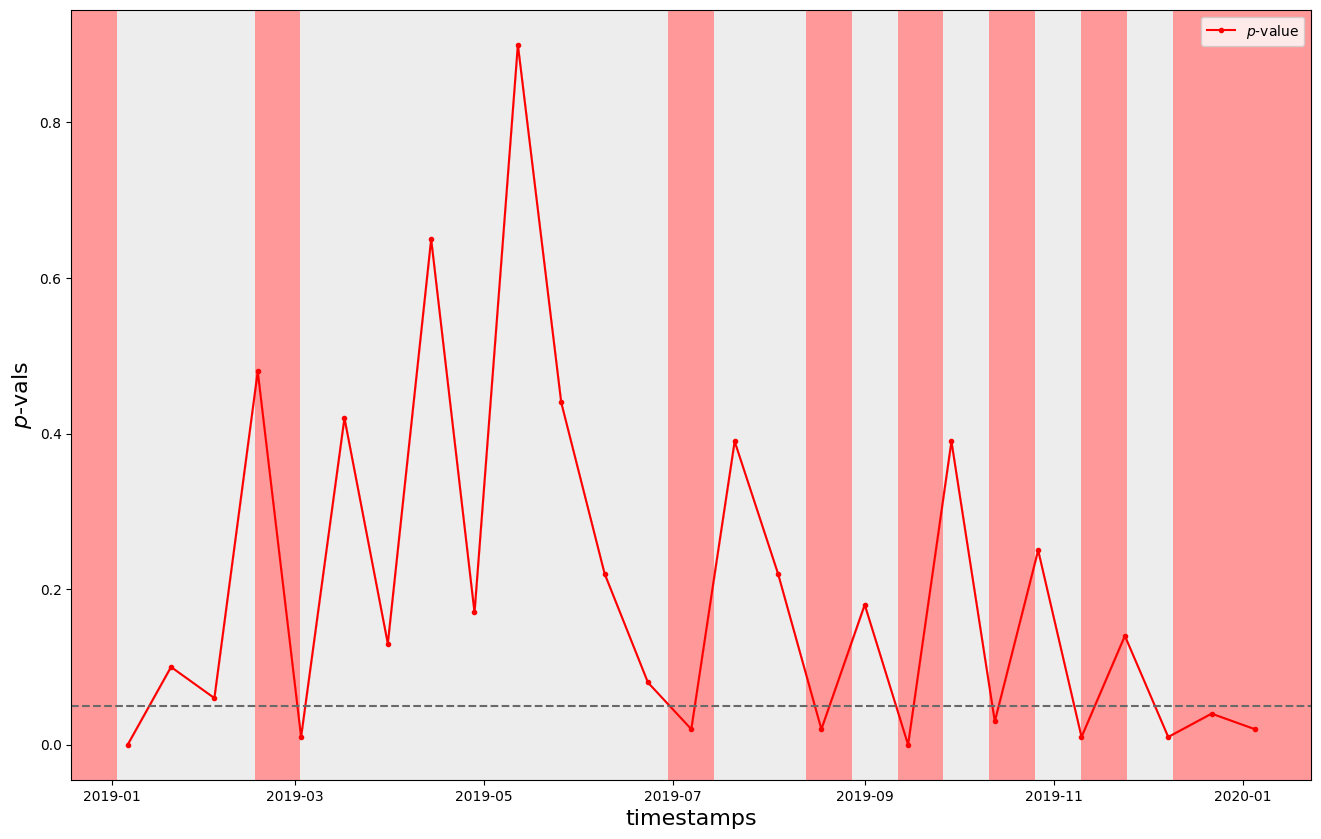

In [6]:
model = DenseNet(weights="densenet121-res224-all")
detector = Detector(
    "rolling_window_drift",
    reductor=Reductor(dr_method="bbse-soft", model=model, device=device),
    tester=TSTester(tester_method="mmd"),
    source_sample_size=200,
    target_sample_size=50,
    timestamp_column="timestamp",
    window_size="2W",
)

results = detector.detect_shift(source_ds, target_ds)
plot_drift_timeseries(results)